In [2]:
import pandas as pd
import numpy as np
import ast
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [3]:
ia_P_path = "full/ia_P.csv"
df_P = pd.read_csv(ia_P_path)

### Answers

In [39]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'
q_ind = 'same_critical_span'

df_A_filtered['text_id'] = (
    df_A_filtered[article_col].astype(str) + '_' +
    df_A_filtered[difficulty_col].astype(str) + '_' +
    df_A_filtered[batch_col].astype(str) + '_' +
    df_A_filtered[paragraph_col].astype(str) + '_' +
    df_A_filtered[q_ind].astype(str)
    )

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

C:\Users\deeth\AppData\Local\Temp\ipykernel_13820\1610736497.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A_filtered['text_id'] = (


In [41]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [42]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [43]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [44]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_area_screen_loc,
    create_area_label,
    create_selected_answer_label
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_area_screen_loc at 0x000002973493B3A0>
<function create_area_label at 0x00000298F3CB4DC0>
<function create_selected_answer_label at 0x00000298F3CB4B80>
<function create_area_screen_loc at 0x000002973493B3A0>
<function create_area_label at 0x00000298F3CB4DC0>
<function create_selected_answer_label at 0x00000298F3CB4B80>


In [46]:
def create_mean_area_dwell_time_answers(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id', 'text_id','area_label', 'area_screen_loc', 'selected_answer_label', 'selected_answer_position'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [47]:
hunters_dwells_a = create_mean_area_dwell_time_answers(df_base_features_h)
gatherers_dwells_a = create_mean_area_dwell_time_answers(df_base_features_g)

In [48]:
def pivot_answers(df):
    dwell_wide = (
        df
        .pivot(
            index=['TRIAL_INDEX', 'participant_id', 'text_id'],
            columns='area_label',
            values='mean_dwell_time'
        )
        .rename_axis(None, axis=1)
        .reset_index()
    )

    loc_wide = (
        df
        .pivot(
            index=['TRIAL_INDEX', 'participant_id', 'text_id'],
            columns='area_label',
            values='area_screen_loc'
        )
        .add_prefix('loc_')
        .rename_axis(None, axis=1)
        .reset_index()
    )

    sel = (
        df
        [['TRIAL_INDEX', 'participant_id', 'text_id',
          'selected_answer_label', 'selected_answer_position']]
        .drop_duplicates()
    )

    ans_wide = (
        dwell_wide
        .merge(loc_wide, on=['TRIAL_INDEX', 'participant_id', 'text_id'])
        .merge(sel,      on=['TRIAL_INDEX', 'participant_id', 'text_id'])
    )

    ans_wide['dwell_selected'] = ans_wide.apply(
        lambda r: r[f"answer_{r.selected_answer_label}"], axis=1
    )
    ans_wide['screenloc_selected'] = ans_wide.apply(
        lambda r: r[f"loc_answer_{r.selected_answer_label}"], axis=1
    )
    return ans_wide

ans_wide_h = pivot_answers(hunters_dwells_a)
ans_wide_g = pivot_answers(gatherers_dwells_a)


### Texts

In [35]:
df_P_f  = df_P[(df_P['repeated_reading_trial'] == False) & ((df_P['practice_trial'] == False))]

df_P_hunters = df_P_f[df_P_f['question_preview'] == True].copy()
df_P_gatherers = df_P_f[df_P_f['question_preview'] == False].copy()

In [36]:
def create_mean_area_dwell_time_text(df):
    return df.groupby(['TRIAL_INDEX', 'participant_id', 'auxiliary_span_type'], as_index=False).agg(mean_dwell_time=("IA_DWELL_TIME", "mean"))

In [37]:
hunters_dwells_p = create_mean_area_dwell_time_text(df_P_hunters)
gatherers_dwells_p = create_mean_area_dwell_time_text(df_P_gatherers)

In [38]:
text_wide_h = (
    hunters_dwells_p
    .pivot(index=['TRIAL_INDEX','participant_id'],
           columns='auxiliary_span_type',
           values='mean_dwell_time')
    .reset_index()
)

text_wide_g = (
    gatherers_dwells_p
    .pivot(index=['TRIAL_INDEX','participant_id'],
           columns='auxiliary_span_type',
           values='mean_dwell_time')
    .reset_index()
)

### Merge Texts and Answers

In [49]:
merged_h = pd.merge(text_wide_h, ans_wide_h,
                  on=['TRIAL_INDEX','participant_id'])

merged_g = pd.merge(text_wide_g, ans_wide_g,
                  on=['TRIAL_INDEX','participant_id'])

In [50]:
merged_h

,TRIAL_INDEX,participant_id,critical,distractor,outside,text_id,answer_A,answer_B,answer_C,answer_D,question,loc_answer_A,loc_answer_B,loc_answer_C,loc_answer_D,loc_question,selected_answer_label,selected_answer_position,dwell_selected,screenloc_selected
0,3,l10_338,169.090909,90.400000,215.322222,8_Ele_3_1_2,932.000000,1186.000000,375.166667,618.600000,28.600000,answer_1,answer_3,answer_2,answer_0,question,B,3,1186.000000,answer_3
1,3,l10_39,117.411765,135.428571,56.977778,3_Ele_1_1_1,326.555556,93.727273,53.428571,296.333333,15.846154,answer_0,answer_3,answer_2,answer_1,question,D,1,296.333333,answer_1
2,3,l11_342,509.382979,124.000000,199.032609,3_Ele_3_1_0,134.333333,39.666667,0.000000,0.000000,22.625000,answer_1,answer_0,answer_3,answer_2,question,A,1,134.333333,answer_1
3,3,l11_40,179.500000,218.050000,143.650000,9_Ele_1_1_0,274.750000,41.166667,72.571429,0.000000,0.000000,answer_3,answer_2,answer_0,answer_1,question,A,3,274.750000,answer_3
4,3,l14_349,155.047619,146.846154,209.184211,5_Ele_3_1_0,209.333333,65.750000,24.800000,26.750000,16.272727,answer_1,answer_0,answer_3,answer_2,question,A,1,209.333333,answer_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,90,l42_488,113.019231,131.107143,95.825000,3_Adv_1_5_1,101.333333,204.333333,143.500000,249.000000,0.000000,answer_3,answer_0,answer_1,answer_2,question,B,0,204.333333,answer_0
9715,93,l5_175,180.500000,101.800000,79.085106,6_Adv_2_1_1,168.000000,62.600000,93.600000,357.600000,0.000000,answer_0,answer_1,answer_3,answer_2,question,A,0,168.000000,answer_0
9716,94,l5_175,194.678571,143.666667,84.880000,6_Ele_2_2_2,493.625000,122.111111,48.166667,61.857143,0.000000,answer_2,answer_1,answer_0,answer_3,question,A,2,493.625000,answer_2
9717,95,l5_175,129.571429,281.000000,195.109091,6_Adv_2_3_0,255.500000,226.555556,71.250000,65.166667,0.000000,answer_2,answer_3,answer_1,answer_0,question,A,2,255.500000,answer_2


In [51]:
merged_h.to_csv('merged_hunters.csv', index=False)
merged_g.to_csv('merged_gatherers.csv', index=False)

In [3]:
merged_h = pd.read_csv('merged_hunters.csv')
merged_g = pd.read_csv('merged_gatherers.csv')

### Simple Correlation

In [4]:
def corr_map_num(df):
    cols = ['critical', 'distractor', 'outside',
            'answer_A', 'answer_B', 'answer_C', 'answer_D',
            'dwell_selected']

    corr = df[cols].corr()

    plt.figure()
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(cols)), cols)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

In [5]:
def prop_map(df):

    text_cols = ['critical', 'distractor', 'outside']
    ans_cols  = ['answer_A', 'answer_B', 'answer_C', 'answer_D']

    df[[f"{c}_prop" for c in text_cols]] = df[text_cols].div(df[text_cols].sum(axis=1), axis=0)
    df[[f"{c}_prop" for c in ans_cols]]   = df[ans_cols].div(df[ans_cols].sum(axis=1), axis=0)

    df['selected_prop'] = df['dwell_selected'] / df[ans_cols].sum(axis=1)


    cols_prop = [f"{c}_prop" for c in text_cols + ans_cols] + ['selected_prop']
    corr_prop = df[cols_prop].corr()


    plt.figure()
    plt.imshow(corr_prop, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(cols_prop)), cols_prop, rotation=45, ha='right')
    plt.yticks(range(len(cols_prop)), cols_prop)
    plt.title('Correlation Matrix Heatmap (Proportions)')
    plt.tight_layout()
    plt.show()

In [6]:
def ABC_corr(df):

    corr_crit_A = df['critical_prop'].corr(df['answer_A_prop'])
    corr_crit_B = df['critical_prop'].corr(df['answer_B_prop'])
    corr_dist_C = df['distractor_prop'].corr(df['answer_C_prop'])
    print(f"Correlation between critical dwell and answer_A dwell: {corr_crit_A:.3f}")
    print(f"Correlation between critical dwell and answer_B dwell: {corr_crit_B:.3f}")
    print(f"Correlation between distractor dwell and answer_C dwell: {corr_dist_C:.3f}")

    plt.figure()
    plt.scatter(df['critical'], df['answer_A'])
    plt.xlabel('Critical span dwell time (ms)')
    plt.ylabel('Answer_A dwell time (ms)')
    plt.title('Critical span vs. Answer_A dwell')
    plt.tight_layout()
    plt.show()


    plt.figure()
    plt.scatter(df['critical'], df['answer_B'])
    plt.xlabel('Critical span dwell time (ms)')
    plt.ylabel('Answer_B dwell time (ms)')
    plt.title('Critical span vs. Answer_B dwell')
    plt.tight_layout()
    plt.show()


    plt.figure()
    plt.scatter(df['distractor'], df['answer_C'])
    plt.xlabel('Distractor span dwell time (ms)')
    plt.ylabel('Answer_C dwell time (ms)')
    plt.title('Distractor span vs. Answer_C dwell')
    plt.tight_layout()
    plt.show()

In [7]:
merged_h.columns


Index(['TRIAL_INDEX', 'participant_id', 'critical', 'distractor', 'outside',
       'text_id', 'answer_A', 'answer_B', 'answer_C', 'answer_D', 'question',
       'loc_answer_A', 'loc_answer_B', 'loc_answer_C', 'loc_answer_D',
       'loc_question', 'selected_answer_label', 'selected_answer_position',
       'dwell_selected', 'screenloc_selected'],
      dtype='object')

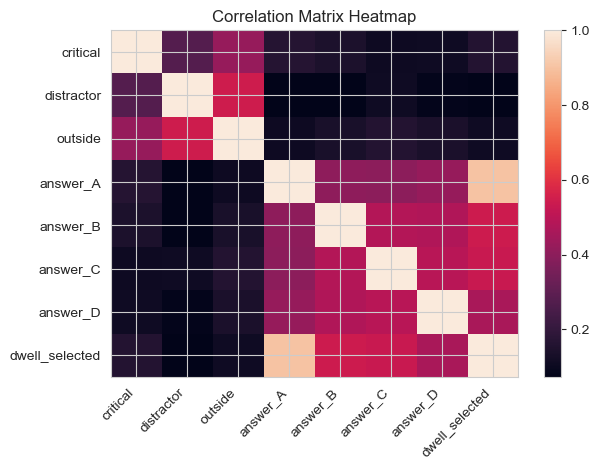

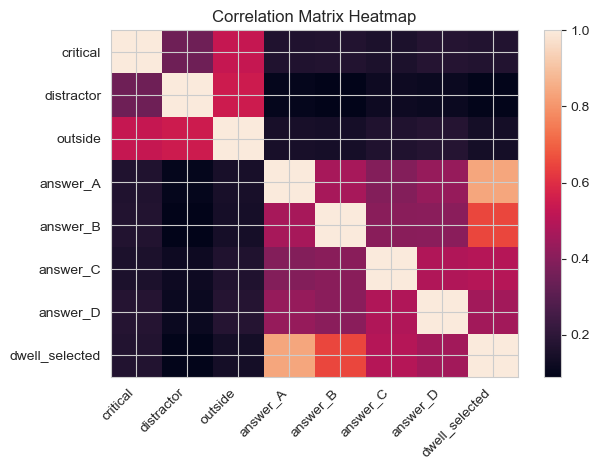

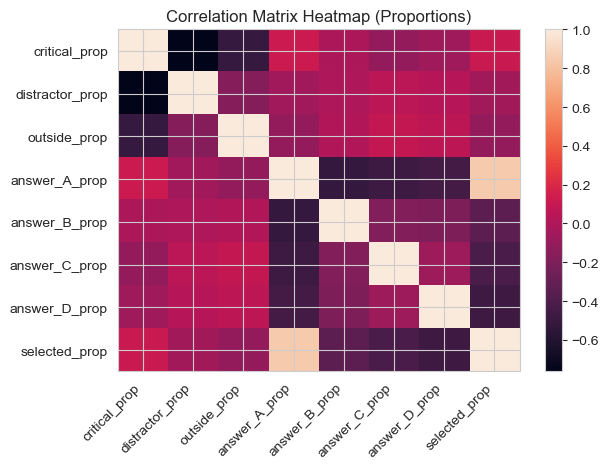

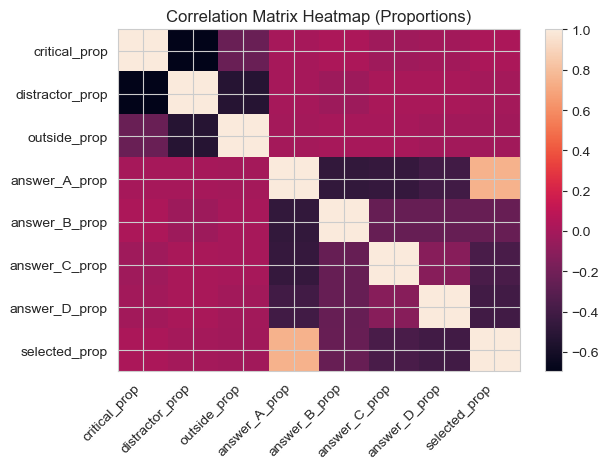

Correlation between critical dwell and answer_A dwell: 0.120
Correlation between critical dwell and answer_B dwell: -0.007
Correlation between distractor dwell and answer_C dwell: 0.053


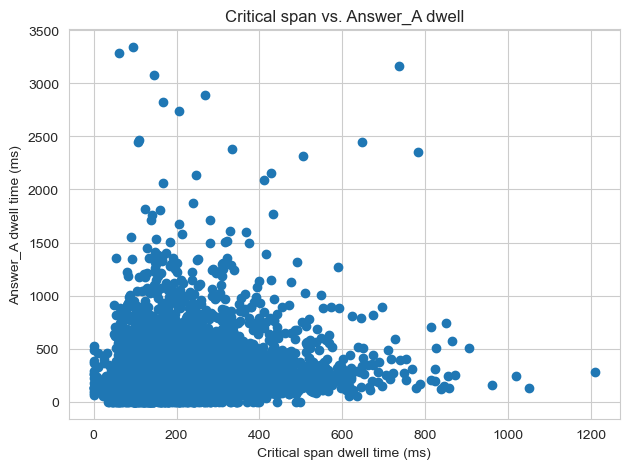

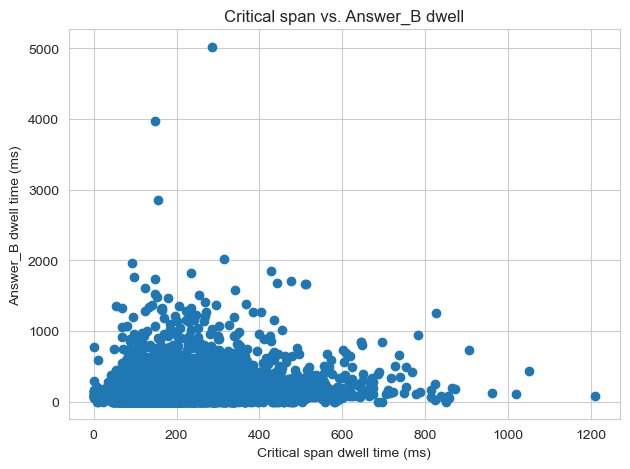

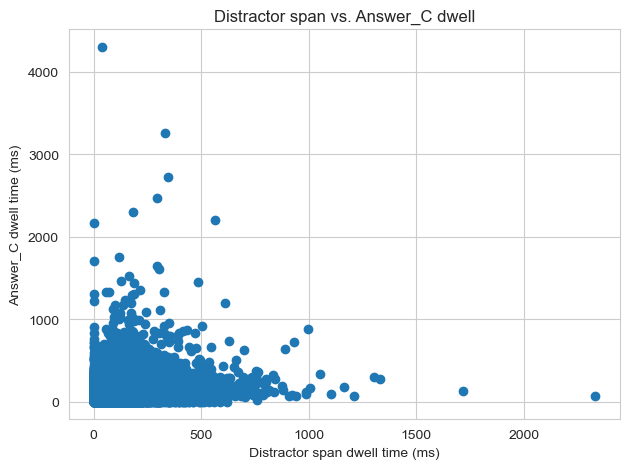

Correlation between critical dwell and answer_A dwell: 0.001
Correlation between critical dwell and answer_B dwell: 0.030
Correlation between distractor dwell and answer_C dwell: 0.014


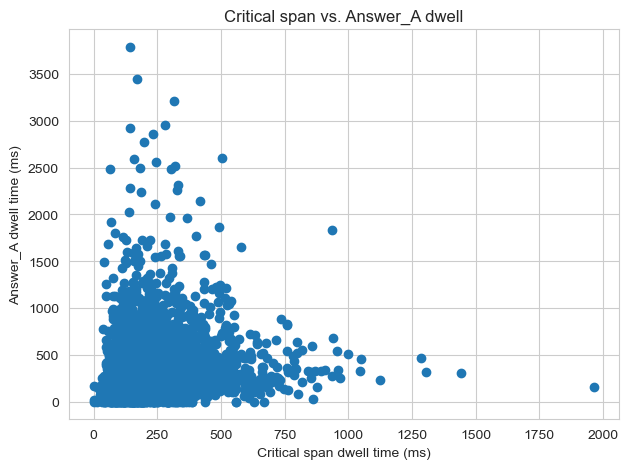

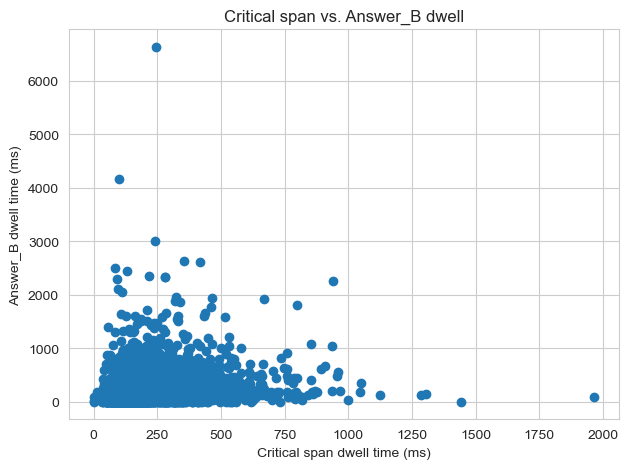

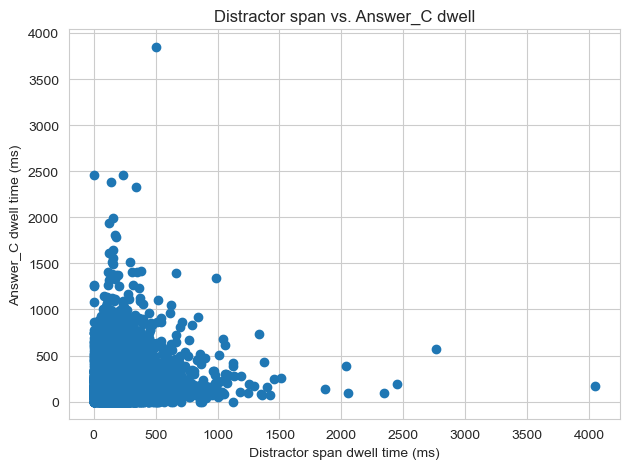

In [8]:
corr_map_num(merged_h)
corr_map_num(merged_g)

prop_map(merged_h)
prop_map(merged_g)

ABC_corr(merged_h)
ABC_corr(merged_g)

In [9]:
merged_h['participant_id'] = merged_h['participant_id'].astype(str)
merged_h['text_id'] = merged_h['text_id'].astype(str)

In [10]:
!pip install pymer4

In [21]:
merged_h

,TRIAL_INDEX,participant_id,critical,distractor,outside,text_id,answer_A,answer_B,answer_C,answer_D,...,dwell_selected,screenloc_selected,critical_prop,distractor_prop,outside_prop,answer_A_prop,answer_B_prop,answer_C_prop,answer_D_prop,selected_prop
0,3,l10_338,169.090909,90.400000,215.322222,8_Ele_3_1_2,932.000000,1186.000000,375.166667,618.600000,...,1186.000000,answer_3,0.356121,0.190391,0.453488,0.299508,0.381134,0.120564,0.198794,0.381134
1,3,l10_39,117.411765,135.428571,56.977778,3_Ele_1_1_1,326.555556,93.727273,53.428571,296.333333,...,296.333333,answer_1,0.378970,0.437123,0.183907,0.424073,0.121717,0.069384,0.384826,0.384826
2,3,l11_342,509.382979,124.000000,199.032609,3_Ele_3_1_0,134.333333,39.666667,0.000000,0.000000,...,134.333333,answer_1,0.611933,0.148964,0.239102,0.772031,0.227969,0.000000,0.000000,0.772031
3,3,l11_40,179.500000,218.050000,143.650000,9_Ele_1_1_0,274.750000,41.166667,72.571429,0.000000,...,274.750000,answer_3,0.331670,0.402901,0.265429,0.707229,0.105966,0.186805,0.000000,0.707229
4,3,l14_349,155.047619,146.846154,209.184211,5_Ele_3_1_0,209.333333,65.750000,24.800000,26.750000,...,209.333333,answer_1,0.303374,0.287326,0.409300,0.640882,0.201296,0.075926,0.081896,0.640882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,90,l42_488,113.019231,131.107143,95.825000,3_Adv_1_5_1,101.333333,204.333333,143.500000,249.000000,...,204.333333,answer_0,0.332457,0.385664,0.281879,0.145142,0.292671,0.205538,0.356648,0.292671
9715,93,l5_175,180.500000,101.800000,79.085106,6_Adv_2_1_1,168.000000,62.600000,93.600000,357.600000,...,168.000000,answer_0,0.499467,0.281694,0.218839,0.246407,0.091816,0.137284,0.524494,0.246407
9716,94,l5_175,194.678571,143.666667,84.880000,6_Ele_2_2_2,493.625000,122.111111,48.166667,61.857143,...,493.625000,answer_2,0.459988,0.339457,0.200555,0.680149,0.168253,0.066367,0.085231,0.680149
9717,95,l5_175,129.571429,281.000000,195.109091,6_Adv_2_3_0,255.500000,226.555556,71.250000,65.166667,...,255.500000,answer_2,0.213927,0.463941,0.322132,0.413115,0.366315,0.115203,0.105367,0.413115


In [26]:
from pymer4.models import Lmer

# general reading times

# plot this: (Keren article)

model = Lmer('answer_A ~ critical_prop + (1|participant_id) + (1|text_id)', data=merged_h)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical_prop+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -64607.856 	 AIC: 129225.712

Random effects:

                       Name        Var      Std
text_id         (Intercept)  12344.311  111.105
participant_id  (Intercept)   3695.120   60.787
Residual                     29296.805  171.163

No random effect correlations specified

Fixed effects:

               Estimate   2.5_ci  97.5_ci      SE        DF  T-stat  P-val  \
(Intercept)     241.360  224.545  258.174   8.579  1329.548  28.133  0.000   
critical_prop  

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [13]:
model = Lmer('answer_B ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_h)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_B~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -63206.026 	 AIC: 126426.052

Random effects:

                       Name        Var      Std
text_id         (Intercept)   5594.404   74.796
participant_id  (Intercept)   1186.426   34.445
Residual                     23120.036  152.053

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   124.982  113.576  136.388  5.819  1064.591  21.477  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [14]:
model = Lmer('answer_C ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_h)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_C~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -62019.597 	 AIC: 124053.194

Random effects:

                       Name        Var      Std
text_id         (Intercept)   4166.495   64.548
participant_id  (Intercept)    882.701   29.710
Residual                     18182.424  134.842

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   103.762  93.777  113.748  5.095  1072.680  20.367  0.000  ***
criti

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [16]:
model = Lmer('answer_D ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_h)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_D~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9719	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -60874.716 	 AIC: 121763.431

Random effects:

                       Name        Var      Std
text_id         (Intercept)   4315.526   65.693
participant_id  (Intercept)    738.371   27.173
Residual                     14042.848  118.503

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   111.561  102.407  120.716  4.671  1120.555  23.885  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [17]:
model = Lmer('answer_A ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_g)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_A~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9717	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -65289.570 	 AIC: 130593.141

Random effects:

                       Name        Var      Std
text_id         (Intercept)  14185.909  119.105
participant_id  (Intercept)   2989.077   54.672
Residual                     33938.573  184.224

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   195.580  178.836  212.325  8.543   960.988  22.893  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [18]:
model = Lmer('answer_B ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_g)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_B~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9717	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -64697.445 	 AIC: 129408.891

Random effects:

                       Name        Var      Std
text_id         (Intercept)   9018.925   94.968
participant_id  (Intercept)   1984.158   44.544
Residual                     31027.605  176.147

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   143.644  129.008  158.280  7.467   860.836  19.236  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [19]:
model = Lmer('answer_C ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_g)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_C~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9717	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -62554.213 	 AIC: 125122.427

Random effects:

                       Name        Var      Std
text_id         (Intercept)   5969.526   77.263
participant_id  (Intercept)   1738.049   41.690
Residual                     19794.633  140.693

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   122.988  110.630  135.347  6.305   848.518  19.505  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [20]:
model = Lmer('answer_D ~ critical + distractor + outside + (1|participant_id) + (1|text_id)', data=merged_g)
result = model.fit()
print(result)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: answer_D~critical+distractor+outside+(1|participant_id)+(1|text_id)

Family: gaussian	 Inference: parametric

Number of observations: 9717	 Groups: {'text_id': 970.0, 'participant_id': 180.0}

Log-likelihood: -61827.341 	 AIC: 123668.682

Random effects:

                       Name        Var      Std
text_id         (Intercept)   5382.082   73.363
participant_id  (Intercept)   1297.979   36.027
Residual                     17011.410  130.428

No random effect correlations specified

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)   113.076  101.832  124.319  5.736   863.521  19.712  0.000  ***
cri

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
